# Gradient Boosting Regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

import scripts.load_data as load

%matplotlib inline

In [2]:
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.ensemble
import sklearn.model_selection
import sklearn.feature_selection
import sklearn.metrics

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from time import time

In [3]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [10]:
#output_columns = ["Ca","P","pH","SOC","Sand"]
output_columns=["Ca"]

X,targets=load.load_training_spectra()

y=targets[output_columns]


## Gradient Boosted Trees
Gradient boosted trees can be regarded as the smarter older sibling to the [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) ensemble method.
Gradient Boosted Trees are iteratively corrected, with the residuals of the previous tree 
providing the basis for building the subsequent tree.  
The user specifies the loss function to be optimized,
and here we use least squares regression,
the default loss function for scikit-learn's [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).
More info and intuition about gradient boosted trees can be found [here](http://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/).

To help speed up the task of training these trees, 
we perform some dimensionality reduction 
and feature selection below

In [11]:
pca = skl.decomposition.PCA()
X_transformed = pca.fit_transform(X)


In [12]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X_transformed,y,test_size=0.2)

Scikit-learn's **GradientBoostingRegressor** doesn't work for multiple targets, so we will train for one target at a time.  SKL does handle multioutput for instances like this with MultiOutputRegressor, but it seems to make info about the gradient boosting regressor less accessible (like feature importances).  For now we'll only look at one target, Ca.

In [13]:
n_estimators=1000
clf_Ca=skl.ensemble.GradientBoostingRegressor(n_estimators=n_estimators)

In [14]:
start=time()
clf_Ca.fit(X_train,y_train.values.ravel())
print("GBR took %.2f seconds for %d estimators"
      % ((time() - start), n_estimators))

GBR took 72.67 seconds for 1000 estimators


In [15]:
y_pred = clf_Ca.predict(X_test)

Here are some scoring metrics for our first pass at this model:

In [16]:
skl.metrics.mean_squared_error(y_test,y_pred)

0.10273138067150087

In [17]:
skl.metrics.r2_score(y_test,y_pred)

0.90396719449426621

## Feature importances and selection

There are ways to save time without giving up model performance.  One way is by using GradientBoostingRegressor's **feature_importances** attribute, which can identify the most important features in determining a split, allowing us to cast out less important features.

Below we print out the highest ranking features
(remember, these are the numbered labels of our Principal Components):

In [18]:
importances=clf_Ca.feature_importances_
indices = np.argsort(importances)[::-1]

#Print the feature ranking
print("Feature ranking:")

#for f in range(X.shape[1]):
for f in range(10):
    print("{:d}.  feature {:d} ({:f})".format(f+1,indices[f],importances[indices[f]]))

Feature ranking:
1.  feature 6 (0.016930)
2.  feature 4 (0.008544)
3.  feature 0 (0.007909)
4.  feature 5 (0.007580)
5.  feature 3 (0.007365)
6.  feature 2 (0.007340)
7.  feature 8 (0.006608)
8.  feature 103 (0.005031)
9.  feature 48 (0.004830)
10.  feature 32 (0.004553)


For the most part, the important features appear to also correspond to the the PCs that explain the most variance.  
However, one shouldn't read too much into the feature importances - 
a low rank does not necessarily mean that the feature isn't important in determining outputs, 
because there may be high correlation between features.  

For more information, you can read [this post](http://alexperrier.github.io/jekyll/update/2015/08/27/feature-importance-random-forests-gini-accuracy.html) 
describing feature engineering and selection in random forests - 
most insights will apply to GBRTs as well.

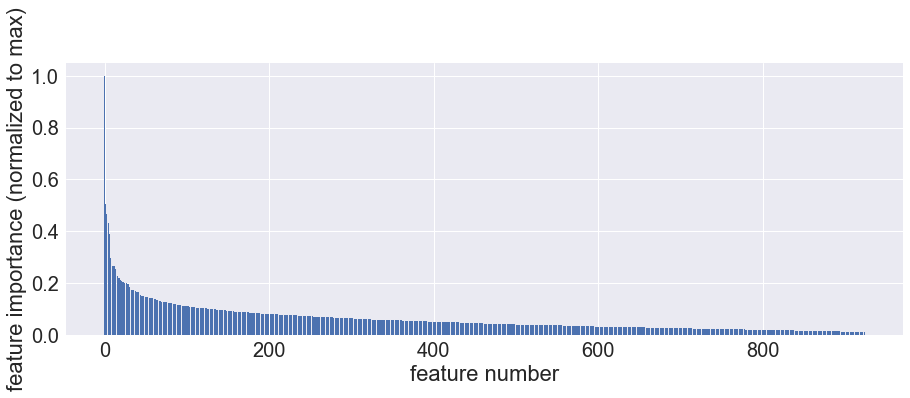

In [19]:
plt.figure(figsize=(15,5))
plt.bar(range(len(X_train)),
        clf_Ca.feature_importances_[indices[range(len(X_train))]]/clf_Ca.feature_importances_[indices[0]])
plt.xlabel('feature number')
plt.ylabel('feature importance (normalized to max)')

Let's pick out the more important features to train on GradientBoostingRegressor again.  
The reduction in dimensionality will allow us to explore the hyperparameter space in a more timely fashion.  
Here we use skl's  **SelectFromModel**, and define a threshold above which we deem a feature important.

In [20]:
sfm = skl.feature_selection.SelectFromModel(clf_Ca,threshold=0.002)
sfm.fit(X_train,y_train.values.ravel()) #training the selector

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
        prefit=False, threshold=0.002)

In [21]:
sfm.get_support(indices=True) #This array lists the feature indices identified as important

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   16,   19,   22,   24,   25,   27,   30,   31,
         32,   33,   34,   38,   40,   41,   42,   48,   52,   54,   55,
         61,   63,   64,   65,   68,   69,   76,   82,   85,   87,   99,
        103,  114,  120,  128,  134,  136,  138,  142,  156,  161,  163,
        167,  205,  207,  261,  265,  296,  297,  319,  339,  354,  455,
        464,  472,  473,  476,  506,  561,  601,  617,  621,  648,  656,
        682,  707,  714,  779,  815,  834,  861,  918,  961,  993, 1016,
       1143, 1144])

Now let's transform our data to a subset that only includes the "important" features,

In [22]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

and train a new GBR with this curated feature set.

In [23]:
clf_Ca_important=skl.ensemble.GradientBoostingRegressor(n_estimators=n_estimators)
clf_Ca_important.fit(X_important_train,y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Here we find the mean squared error on our test subset, using all features

In [24]:
y_pred = clf_Ca.predict(X_test)

In [25]:
skl.metrics.mean_squared_error(y_test,y_pred)

0.10273138067150087

Now we find the mean squared error again, this time with only our selected features

In [26]:
y_important_pred = clf_Ca_important.predict(X_important_test)

In [27]:
skl.metrics.mean_squared_error(y_test,y_important_pred)

0.090211174902734809

Reducing the number of features shouldn't increase the error much - error may even go down!  If error increased by an uncomfortable amount, try decreasing the feature_importance threshold to include more features.

At this point one would usually use Randomized or Grid Search cross-validation 
to tune hyperparameters that optimize model performance.  This can be time-consuming,
so some pre-determined hyperparameters are provided in the cell below
if you're eager to immediately fit and examine a model.

In [28]:
params = {'n_estimators':3000,
          'max_depth':3,
          'min_samples_split':15,
          'min_samples_leaf':3,
          'max_features':0.8,
          'learning_rate':0.01}
clf_Ca_final = skl.ensemble.GradientBoostingRegressor(**params)

In [29]:
clf_Ca_final.fit(X_important_train,y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=0.8,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=15,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Take a look at our R-squared value on our test data:

In [30]:
clf_Ca_final.score(X_important_test,y_test)

0.90988958671670139

Let's compute the deviance at each stage (n_estimators total stages) for the training and test sets.  Each stage does appear to improve performance!

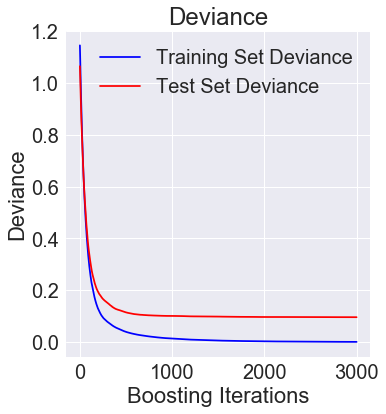

In [31]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf_Ca_final.staged_predict(X_important_test)):
    test_score[i] = clf_Ca_final.loss_(y_test.values.ravel(), y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf_Ca_final.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [32]:
test_score

array([ 1.06419407,  1.04985184,  1.0335442 , ...,  0.09638839,
        0.09638768,  0.09639588])

## RandomizedSearch cross-validation: when there's not enough time for GridSearch
We used the feature_selection package to pare down our feature list to some important ones.  
Now the **model_selection** package will help us to explore the hyperparameter space 
and pin down the right combination of hyperparameters that gives us the best model.  

**GridSearchCV** loops through every combination of user-supplied lists of hyperparameters - 
with more than a few parameters, and more than a few values tried for each parameter, 
this can compound into a lot of iterations.  

**RandomizedSearchCV** only calculates for randomly selected parameter sets, 
selected from user-supplied distribution functions (here listed in param_dist).  
It can save a lot of time without too much degradation in performance. 
Distribution functions here come from the scipy.stats package.

In [ ]:
clf_cv = skl.ensemble.GradientBoostingRegressor()

In [ ]:
param_dist = {"n_estimators":sp_randint(50,200),
              "max_features":sp_uniform(loc=0.4,scale=0.5),
              "min_samples_leaf":sp_randint(1,20),
              "min_samples_split":sp_randint(2,25),
              "max_depth":sp_randint(2,8),
              "subsample":sp_uniform(loc=.5,scale=.5),
             }

In [ ]:
n_iter_search=1000
random_search=skl.model_selection.RandomizedSearchCV(clf_cv,
                                                     param_distributions=param_dist,
                                                     n_iter=n_iter_search,
                                                     n_jobs=-1
                                                    )

In [ ]:
start=time()
random_search.fit(X_important_train,y_train.values.ravel())
print("RandomizedSearchCV took %.2f seconds for %d iterations"
      % ((time() - start), n_iter_search))

Let's print out the info for the highest-ranking models.
Hopefully a winning list of hyperparameters will emerge!

In [ ]:
report(random_search.cv_results_,n_top=10)

To further improve performance we can halve the learning rate and double n_estimators.

If hand-tuning parameters is more your style, 
you can try a greedy cross-validation scheme, 
where hyperparameters are tuned and fixed one by one.

A nicely laid out approach is outlined [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).  
The hyperparameters are tuned in a specific order, 
with the more important parameters appearing first:
1. Tune an appropriate balance of n_estimators and learning_rate
2. Tune tree parameters
    a. max_depth and num_samples_split
    b. min_samples_leaf
    c. max_features
3. Lower learning_rate as you increase n_estimators